# **Mini Batch Training for MLP**

In [123]:
import pickle, gzip, math, os, time, shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import tensor, nn
import torch.nn.functional as F
from fastcore.test import  test_close
from pathlib import Path

# Configs
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=3, linewidth=125, sci_mode=False)
np.set_printoptions(precision=3, linewidth=125)

# Path setup
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
# Loading MNIST data as tensors
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## **Initial Setup**

### **Data**

Copying over the starting cells from the previous NB.

In [2]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

n, m

(50000, 784)

In [3]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [4]:
model = Model(m, nh,  10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [5]:
pred

tensor([[-0.091, -0.212, -0.082,  ..., -0.028,  0.006,  0.061],
        [-0.073, -0.136, -0.143,  ...,  0.030,  0.043,  0.145],
        [-0.186, -0.036,  0.018,  ..., -0.008, -0.003,  0.022],
        ...,
        [-0.026, -0.215, -0.038,  ..., -0.010,  0.090,  0.139],
        [-0.099, -0.094, -0.046,  ..., -0.011,  0.018,  0.108],
        [-0.033, -0.251, -0.064,  ...,  0.005,  0.030,  0.138]], grad_fn=<AddmmBackward0>)

### **Cross Entropy Loss**

We need to improve our loss function from before. Instead of outputting 1 number per image, we will now have 10 one-hot-encoded numbers per image.

The basic formula for Log Softmax is:

$$
\log \text{Softmax}(x_i) = \log (\frac{e^{x_i}}{\sum_{x_j} e^{x_j}})
$$

In [6]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [7]:
log_softmax(pred)

tensor([[-2.373, -2.494, -2.364,  ..., -2.310, -2.276, -2.220],
        [-2.372, -2.436, -2.442,  ..., -2.270, -2.257, -2.155],
        [-2.480, -2.330, -2.275,  ..., -2.302, -2.297, -2.271],
        ...,
        [-2.329, -2.519, -2.342,  ..., -2.314, -2.214, -2.165],
        [-2.382, -2.377, -2.329,  ..., -2.294, -2.265, -2.175],
        [-2.329, -2.547, -2.360,  ..., -2.292, -2.266, -2.159]], grad_fn=<LogBackward0>)

Using the formula: $$ \log\left(\frac{a}{b}\right) = \log(a) - \log(b)$$ allows us to simplify the `log_softmax()` function further.

In [8]:
# From the log rule above and x.exp().log() = x since exp() and log() cancel out.
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

Also, we can simplify things even further by using the [LogSumExp](https://en.wikipedia.org/wiki/LogSumExp) trick.

This allows us to compute the log of the sum of exponentials in a more "stable" way i.e. it prevents numerical underflow or overflow when dealing with log probabilities. The mathematical representation for this is:

$$
\log \sum_{i} e^{x_i} = a + \log \sum_{i} e^{x_i - a}
$$ 

where $a = \max(x_i)$



In [9]:
def logsumexp(x):
    # Taking the max on the last dim
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

In [10]:
# Rewriting log_softmax() using logsumexp() from PyTorch
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [11]:
test_close(logsumexp(pred), pred.logsumexp(-1))

sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.373, -2.494, -2.364,  ..., -2.310, -2.276, -2.220],
        [-2.372, -2.436, -2.442,  ..., -2.270, -2.257, -2.155],
        [-2.480, -2.330, -2.275,  ..., -2.302, -2.297, -2.271],
        ...,
        [-2.329, -2.519, -2.342,  ..., -2.314, -2.214, -2.165],
        [-2.382, -2.377, -2.329,  ..., -2.294, -2.265, -2.175],
        [-2.329, -2.547, -2.360,  ..., -2.292, -2.266, -2.159]], grad_fn=<SubBackward0>)

So, the cross entropy loss can be rewritten as:

$$
- \sum x \log p(x)
$$

We can index into our 1-hot encoded x's using PyTorch's (and, NumPy's) advanced indexing methods.

In [12]:
# Let's pick a sample
y_train[:3]

tensor([5, 0, 4])

In [13]:
# Note the positioning of the indices
sm_pred[0, 5], sm_pred[1, 0], sm_pred[2, 4]

(tensor(-2.200, grad_fn=<SelectBackward0>),
 tensor(-2.372, grad_fn=<SelectBackward0>),
 tensor(-2.355, grad_fn=<SelectBackward0>))

In [14]:
# The indexing method allows us to get these values as follows
sm_pred[[0, 1, 2], y_train[:3]]

tensor([-2.200, -2.372, -2.355], grad_fn=<IndexBackward0>)

In [15]:
# Calculating negative log likelihood loss
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [16]:
loss = nll(sm_pred, y_train)
loss

tensor(2.300, grad_fn=<NegBackward0>)

In [17]:
# PyTorch's version
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

`F.log_softmax` and `F.nll_loss` are combined in one function called `F.cross_entropy`.

In [18]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## **Basic Training Loop**

In [19]:
# Our loss function
loss_func = F.cross_entropy

In [20]:
bs = 50               # batch size

xb = x_train[0 : bs]  # Mini batch from training data
preds = model(xb)     
preds[0], preds.shape

(tensor([-0.091, -0.212, -0.082,  0.096, -0.035,  0.082, -0.042, -0.028,  0.006,  0.061], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [21]:
# Picking our target, matching the mini-batch size
yb = y_train[0 : bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7,
        6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [22]:
# Apply the loss function
loss_func(preds, yb)

tensor(2.305, grad_fn=<NllLossBackward0>)

Lets find the index of the highest number for each of our 64 predictions.

In [23]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3,
        9, 3, 5, 3, 8, 3, 5, 9, 5, 9, 5])

In [24]:
# Calculating the accuracy of our predictions
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

accuracy(preds, yb)

tensor(0.080)

In [25]:
# Setting a learning rate and number of epochs
lr = 0.5
epochs = 3

In [26]:
# Function to print loss and accuracy after each epoch
def report(loss, preds, yb): print(f'{loss:.3f}, {accuracy(preds, yb):.3f}')

In [27]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.305, 0.080


In [28]:
# Our training loop
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs)) # Create a slice from x_i to x_n or equivalent to bs
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        # Backward pass
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_() #inplace zeroing
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

0.115, 0.980
0.124, 0.940
0.082, 0.960


## **Using Parameters and Optim**

### **Parameters**

Lets rebuild the `nn.Module` class to get a better understanding of whats going on under the hood before implementing it.

In [29]:
# Using PyTorch's nn.Module class and assigning an attribute which is a linear layer
m1 = nn.Module()
m1.foo = nn.Linear(in_features=3, out_features=4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

We can see each of the items or `named_children` (which is an generator function) in the module as well.

In [30]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

We can list the parameters of the module as well.

In [31]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.568,  0.431, -0.300],
         [ 0.126, -0.321, -0.238],
         [ 0.508,  0.038,  0.218],
         [ 0.131, -0.170, -0.237]], requires_grad=True),
 Parameter containing:
 tensor([-0.011, -0.511, -0.392,  0.560], requires_grad=True)]

So, this makes it possible for the `nn.Module` class to inherit attributes when we create model architectures.

In [32]:
class MLP(nn.Module):
    # Inputs, outputs and a single NH layer
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    # As before, we will use the refactore forward() function instead of __call()__ to let
    # PyTorch handle all gradient calcs.
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [33]:
# Calling each layer of the model.
model = MLP(m, nh, 10)

In [34]:
# Listing all the attributes
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [35]:
# And listing all the parameters
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


Since PyTorch can handle all the attributes and parameters for us, we can rewrite the training loop from the earlier section.

In [38]:
import pdb

# Training loop as a function
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            #pdb.set_trace()
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            #Updated section, we no longer need to explicitly call each layer's updates
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [39]:
# Running the training loop function
fit()

0.187, 0.960
0.112, 0.960
0.045, 1.000


The inheritance class makes things extremely streamlined when constructing models, but how does it really work its magic?

At the heart of the action is PyTorch overriding the `__setattr__` function in `nn.Module`. Python documentation defines it as:

> This is the counterpart of `getattr()`. The arguments are an object, a string, and an arbitrary value. The string may name an existing attribute or a new attribute. The function assigns the value to the attribute, provided the object allows it. For example, `setattr(x, 'foobar', 123)` is equivalent to `x.foobar = 123`.

Lets rebuild `nn.Module` as a demo.

In [48]:
class MyModule: # Not having () after the class name is equivalent to calling MyModule(object)
    def __init__(self, n_in, nh, n_out):
        self._modules = {} # Dictionary for storing named children
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __setattr__(self, k, v): # Automatically called when we set attributes in the class
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v) # Ensure attributes are set

    def __repr__(self): return f'{self._modules}' # Return string of dict

    def parameters(self):
        # We can use the yield shortcut to return values from an iterator instead of looping through it.
        for l in self._modules.values(): yield from l.parameters()

In [41]:
mod = MyModule(m, nh, 10)
mod

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

The rest of the functionality works as intended.

In [45]:
for p in mod.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


Now that we have successfully recreated `nn.Module`, we will also need to save or _register_ the various layers of our model. This needs to happen all at once.

### **Registering Modules**

In [46]:
from functools import reduce

Lets create a list of all the layers of our model, which we can then pass to a subclass of `nn.Module` i.e. `Model`. This approach is generally used to build sequential models.

In [47]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [67]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers # Store the list of layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val, layer: layer(val), self.layers, x)

In [68]:
# For reference
reduce(lambda x, y: x+y, [1,2,3])

6

In [69]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [70]:
model(xb).shape

torch.Size([50, 10])

### **nn.ModuleList**

Passing the list of Layers is already handled by `nn.ModuleList`. Reverting to PyTorch.

In [75]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x): # Reductions: reduce() works the same as this block, and is widely used for sequential models
        for l in self.layers: x = l(x)
        return x

In [72]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [73]:
fit()

0.119, 0.960
0.109, 0.960
0.075, 0.980


### **nn.Sequential**

`Sequential` has also been recreated above, so we can revert to PyTorch's `nn.Sequential` class.

In [76]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [77]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.164, 0.940
0.128, 0.960
0.076, 0.960


(tensor(0.026, grad_fn=<NllLossBackward0>), tensor(1.))

In [78]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### **Optimizer**

The `Optimizer` cycles through the parameters and updates them using the gradients and the learning rate. This class also sets the gradients to zero after each backward pass.

In [80]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr # Since params might be a generator

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [83]:
# Creating the model using Sequential from before.
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
# Creating the optimizer
opt = Optimizer(model.parameters())

In [85]:
# Here's an even more updated version of the training loop
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        # Updates 
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.175, 0.960
0.116, 0.980
0.088, 0.980


At this point, we've effectively created an `SGD` optimizer. That means we can use PyTorch's version.

In [86]:
from torch import optim

In [89]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    # Passing the model's parameters to PyTorch's SGD optimizer
    return model, optim.SGD(model.parameters(), lr=lr)

In [90]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.295, grad_fn=<NllLossBackward0>)

In [91]:
# Re-running the training loop again, this time Pytorch has us covered with its classes for the model and optim.
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.114, 0.980
0.092, 0.980
0.058, 1.000


The code could do with additional refactoring, especially where data handling is concerned.

## **Dataset and DataLoader**

### **Dataset**

Handling minibatches of x and y values separately is not optimal. A class which handles mini-batches and additional data related functionality is the next step.

In [92]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    
    def __len__(self ): return len(self.x) # Length of the dataset

    def __getitem__(self, i): return self.x[i], self.y[i] # Grab items, return a tuple of (x, y)

In [93]:
# Creating a new dataset
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
# Ensuring the sizes match
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [103]:
x_train.shape, y_train.shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [112]:
# Feeding in the entire data set gives us
xb, yb = train_ds[:]
xb.shape, yb.shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [113]:
# Picking a much smaller sample
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)

xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

PyTorch also handles datasets this way.

In [115]:
# Creating the model again
model, opt = get_model()

# Re-running the training loop
for epoch in range(epochs):
    for i in range(0, n, bs):
        # Updated data handling
        xb, yb = train_ds[i : min(n, i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.110, 0.980
0.074, 1.000
0.081, 0.980


The for loop handling the data loading part of the loop can also be refactored away.

### **DataLoader**

Instead of looping over batches, we can use a dataloader to further simplify the code.

In [130]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs

    def __iter__(self): # The iterator handles looping through the batches and items.
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [131]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

train_dl, valid_dl

(<__main__.DataLoader at 0x7f34870bf100>,
 <__main__.DataLoader at 0x7f34a0aa7ca0>)

In [132]:
xb, yb = next(iter(valid_dl)) # Iterate through the dataloader object and grab items 
xb.shape

torch.Size([50, 784])

In [133]:
# Checking yb
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7,
        6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4])

tensor(3)

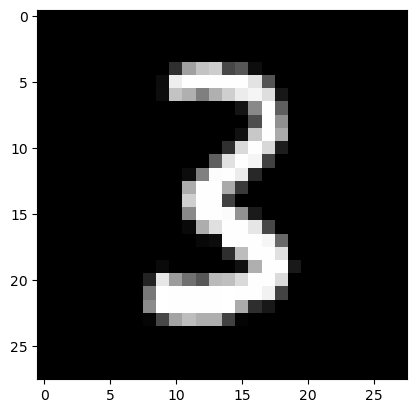

In [134]:
# Plotting the first element of the x batch
plt.imshow(xb[0].view(28, 28));
yb[0]

In [135]:
# As before, reloading the model, the optim and updating the training loop with the new 
# dataloader implementation
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl: # Already loaded
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [136]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.076, 0.980
0.057, 0.980
0.050, 0.980


(tensor(0.045, grad_fn=<NllLossBackward0>), tensor(0.960))